In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

from  data_utilities import *
# from definitions import *
# from run_train_eval_net import run_train_eval_net,run_eval_net

In [2]:
import os
GPU = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=GPU

In [3]:
dataset_name = 'ManyTx'
dataset_path='../../orbit_rf_dataset/data/compact_pkl_datasets/'

compact_dataset = load_compact_pkl_dataset(dataset_path,dataset_name)

tx_list = compact_dataset['tx_list']
rx_list = compact_dataset['rx_list']

equalized = 0

capture_date_list = compact_dataset['capture_date_list']
n_tx = len(tx_list)
n_rx = len(rx_list)
print(n_tx,n_rx)

150 18


In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K


/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/samer/miniconda3/en

In [5]:
 def create_net(ntx_i):

    inputs = Input(shape=(256,2))
    x = Reshape((256,2,1))(inputs)
    x = Conv2D(8,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(32,(3,1),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,1),activation='relu',padding = 'same')(x)
    #x = resnet(x,64,(3,2),'6')
    #x = MaxPool2D((2,2))(x)
    x = Flatten()(x)



    x = Dense(100, activation='relu', kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    # x = Dropout(0.3)(x)
    x = Dense(80, activation='relu',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    x = Dense(ntx_i, activation='softmax',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    ops = x

    classifier = Model(inputs,ops)
    classifier.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer=keras.optimizers.Adam(0.0005))
    
    return classifier

classifier = create_net(5)
classifier.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 2)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 2, 8)         56        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 2, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2, 16)        784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 2, 16)         0         
_________

In [6]:
def evaluate_test(classifier):
    pred = classifier.predict(sig_dfTest)
    acc = np.mean(np.argmax(pred,1)==txidNum_dfTest)

    test_indx = ()
    for indx in range(len(tx_list)):
        cls_indx = np.where(txidNum_dfTest == indx)
        test_indx = test_indx + (cls_indx[0][:n_test_samples],)
    test_indx = np.concatenate(test_indx) 
    acc_bal = np.mean(np.argmax(pred[test_indx,:],1)==txidNum_dfTest[test_indx])
    return acc,acc_bal

In [8]:
TRAIN = True
continue_training = True
nreal = 5

real_list = list(range(nreal))

ntx_list = [10, 45, 80, 115,150]
print(ntx_list)

patience = 5
n_epochs = 100


   



smTest_results_real = []
dfTest_results_real = []
dfTestBal_results_real = []

for ntx_i in ntx_list:
    print("");print("")
    print("ntx_i: {}  ".format(ntx_i))
    fname_w = 'weights/d006_{:04d}.hd5'.format(ntx_i)
    tx_train_list= tx_list[0:ntx_i]

    dataset = merge_compact_dataset(compact_dataset,capture_date_list,tx_train_list,rx_list, equalized=equalized)
    


    train_augset,val_augset,test_augset_smRx =  prepare_dataset(dataset,tx_train_list,
                                                        val_frac=0.1, test_frac=0.1)
    [sig_train,txidNum_train,txid_train,cls_weights] = train_augset
    [sig_valid,txidNum_valid,txid_valid,_] = val_augset
    [sig_smTest,txidNum_smTest,txid_smTest,cls_weights] = test_augset_smRx

    if continue_training:
        skip = os.path.isfile(fname_w)
    else:
        skip = False
    classifier = create_net(ntx_i)
    if TRAIN and not skip:
        filepath = 't_weights_'+GPU
        c=[ keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
          keras.callbacks.EarlyStopping(monitor='val_loss',  patience=patience)]
        history = classifier.fit(sig_train,txid_train,class_weight=cls_weights,
                                 validation_data=(sig_valid , txid_valid),callbacks=c, epochs=n_epochs)
        classifier.load_weights(filepath)
        classifier.save_weights(fname_w,save_format="h5")
    else:
        classifier.load_weights(fname_w)

    smTest_r = classifier.evaluate(sig_smTest,txid_smTest,verbose=0)[1]


    print(smTest_r)
    smTest_results_real.append(smTest_r)
    K.clear_session()
    
    
    


[10, 45, 80, 115, 150]


ntx_i: 10  
0.8155456


ntx_i: 45  
Train on 121513 samples, validate on 15189 samples
Epoch 1/100
121376/121513 [============================>.] - ETA: 0s - loss: 3.4345 - categorical_accuracy: 0.0665
Epoch 00001: val_loss improved from inf to 3.05380, saving model to t_weights_1
121513/121513 [==============================] - 22s 177us/sample - loss: 3.4341 - categorical_accuracy: 0.0666 - val_loss: 3.0538 - val_categorical_accuracy: 0.1274
Epoch 2/100
121024/121513 [============================>.] - ETA: 0s - loss: 2.8348 - categorical_accuracy: 0.1699
Epoch 00002: val_loss improved from 3.05380 to 2.47703, saving model to t_weights_1
121513/121513 [==============================] - 20s 168us/sample - loss: 2.8339 - categorical_accuracy: 0.1701 - val_loss: 2.4770 - val_categorical_accuracy: 0.2719
Epoch 3/100
121312/121513 [============================>.] - ETA: 0s - loss: 2.4040 - categorical_accuracy: 0.2862
Epoch 00003: val_loss improved from 2.47703 to 

[10, 45, 80, 115, 150]
[0.8155456, 0.69589835, 0.566258, 0.549167, 0.53099644]


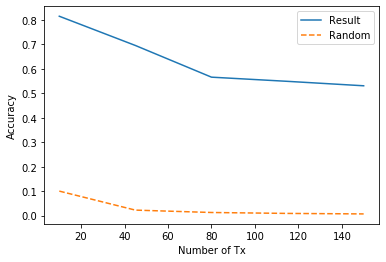

In [10]:
plt.plot(ntx_list,smTest_results_real)
plt.plot(ntx_list,1/np.array(ntx_list),'--')
plt.xlabel('Number of Tx')
plt.ylabel('Accuracy')
plt.legend(['Result','Random'])
print(ntx_list)
print(smTest_results_real)